# Installing Packages and Dependencies

In [1]:
!pip install tensorflow-text==2.4.2
!pip install tf-models-official==2.4
!pip install tensorflow-gpu==2.4.2
!pip install delayed
!pip install alt-profanity-check
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
import joblib
from profanity_check import predict, predict_prob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

     |████████████████████████████████| 3.4 MB 599 kB/s            
     |████████████████████████████████| 394.5 MB 35 kB/s              
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 3.8 MB 33.8 MB/s            
     |████████████████████████████████| 462 kB 49.4 MB/s            
     |████████████████████████████████| 2.9 MB 48.0 MB/s            
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77060 sha256=4f86bdeee4da5fd54f57b27f828394c6ea370f9977af8a3fb02557715c69e6eb
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Succe

2022-01-16 12:00:52.538436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to un

In [2]:
print(tf.__version__)

2.4.2


In [3]:
!nvidia-smi 

Sun Jan 16 12:01:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
tf.test.is_gpu_available()

2022-01-16 12:01:01.456815: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

# Reading Training Data

In [5]:
df_train = pd.read_csv("../input/covid-misinfo/Constraint_English_Train.csv")
df_val = pd.read_csv("../input/covid-misinfo/Constraint_English_Val.csv")
df = pd.concat([df_train, df_val], ignore_index=True)
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [6]:
df.shape

(8560, 3)

# Training Data Insight

In [7]:
df.groupby('label').describe()

id                                                                 
        count         mean          std  min      25%     50%      75%     max
label                                                                         
fake   4080.0  2703.599755  1872.863928  1.0  1095.75  2193.5  4284.25  6419.0
real   4480.0  2649.909152  1884.354217  1.0  1053.75  2119.5  4275.25  6420.0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


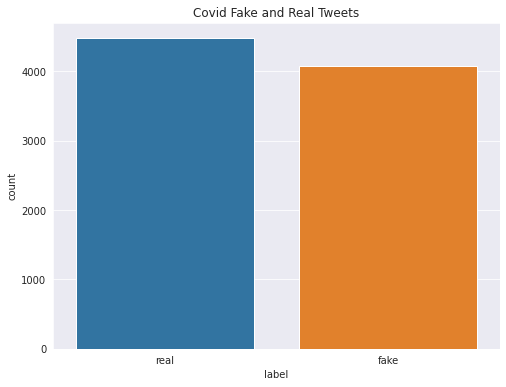

In [8]:
plt.figure(figsize=(8,6))
sns.set_style(style='darkgrid')
sns.countplot(df['label'])
plt.title("Covid Fake and Real Tweets")
plt.show()

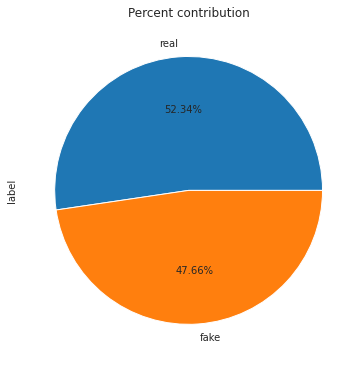

In [9]:
plt.figure(figsize=(6,8))
sns.set_style("darkgrid")
df["label"].value_counts().plot.pie(autopct='%0.2f%%')
plt.title("Percent contribution")
plt.show()

# Data Cleaning

In [10]:
#Data Cleaning
ps = PorterStemmer()
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
en_stopwords = set(stopwords.words("english"))

In [12]:
def cleaner(text):
    try:
        url_re = re.compile(r'(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#\$\%\^\&\*\(\)_\-\=\+\\\/\?\.\:\;\'\,]*)?')
        cleaned = url_re.sub("",text)
        
        hashtag_re = re.compile(r'(#\w+)')
        cleaned = hashtag_re.sub("",cleaned)
        
        screen_name_re = re.compile(r'(@\w+)')
        cleaned = screen_name_re.sub("", cleaned)
        
        emoji_re = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U0001F1F2-\U0001F1F4"  # Macau flag
                u"\U0001F1E6-\U0001F1FF"  # flags
                u"\U0001F600-\U0001F64F"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U0001F1F2"
                u"\U0001F1F4"
                u"\U0001F620"
                u"\u200d"
                u"\u2640-\u2642"
                "]+", flags=re.UNICODE)
        cleaned = emoji_re.sub("",cleaned)
        
        cleaned = cleaned.replace("."," ").replace("//"," ")
        cleaned = re.sub(r'[^a-zA-Z]', " ", cleaned) #Replacing all non-alphabets with " "
        cleaned = re.sub(r'\w+\d+', " ", cleaned) #Removes alphanumeric words

        cleaned = ps.stem(cleaned)

        cleaned = " ".join([word for word in cleaned.split() if len(word)>2]) #Removing words with len<2
        cleaned = " ".join([word for word in cleaned.split() if word not in en_stopwords])

        cleaned = cleaned.strip() #Removing whitespaces
        cleaned = cleaned.lower() #Converting to lower case

    except:
        cleaned = ""
    return cleaned
    
df['tweet'] = df['tweet'].apply(lambda text: cleaner(text))
df.head()

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,testing laboratories india august tests done,real
4,5,populous states generate large case counts loo...,real


# Generating Word Clouds

In [13]:
df

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,testing laboratories india august tests done,real
4,5,populous states generate large case counts loo...,real
...,...,...,...
8555,2136,donald trump wrongly claimed new zealand big s...,fake
8556,2137,current understanding spreads mostly person pe...,real
8557,2138,nothing screams sat around fuck lockdown quite...,fake
8558,2139,birx says covid outbreak control people move,fake


In [14]:
#Function to get word frequencies in the data
def get_word_freqs(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

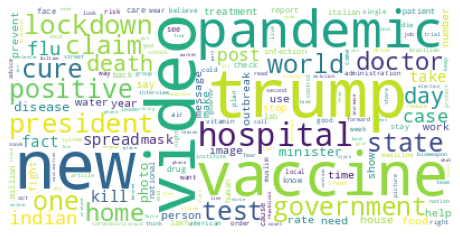

In [15]:
freq_words_fake = get_word_freqs(df[df['label']=='fake'],'tweet')
freq_words_fake = " ".join(freq_words_fake.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_fake)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

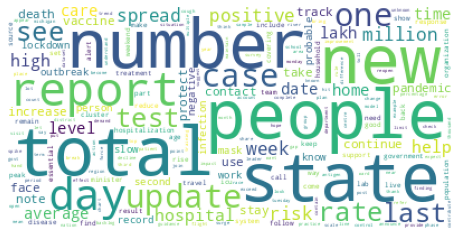

In [16]:
freq_words_real = get_word_freqs(df[df['label']=='real'],'tweet')
freq_words_real = " ".join(freq_words_real.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_real)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [17]:
#splitting the labels
df_real = df[df['label']=='real']
df_real.shape

(4480, 3)

In [18]:
df_fake = df[df['label']=='fake']
df_fake.shape

(4080, 3)

# Downsampling Data

In [19]:
#unbalanced data so we downsample it
df_real_downsampled = df_real.sample(df_fake.shape[0])
df_real_downsampled.shape

(4080, 3)

In [20]:
df_balanced = pd.concat([df_fake, df_real_downsampled])
df_balanced['label'].value_counts()

fake    4080
real    4080
Name: label, dtype: int64

In [21]:
df_balanced['fake'] = df_balanced['label'].apply(lambda x: 1 if x == 'fake' else 0)
df_balanced.sample(5)

,id,tweet,label,fake
3065,3066,education maharashtra rank country five years ...,fake,1
7274,855,president trump tells group high school studen...,fake,1
4700,4701,new cases covid nigeria lagos fct delta edo og...,real,0
2891,2892,part efforts reduce risk infection among healt...,real,0
6394,6395,says donald trump tweeted corona vaccine israe...,fake,1


In [22]:
df_test = pd.read_csv("../input/covid-misinfo/Constraint_English_Test.csv")
df_test['tweet'] = df_test['tweet'].apply(lambda text: cleaner(text))
df_test['fake'] = df_test['label'].apply(lambda x: 1 if x == 'fake' else 0)
y_test = df_test[['fake']]

# Model Construction

In [23]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
    
    return np.array(all_tokens)

In [24]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    return model

In [25]:
%%time
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-01-16 12:01:39.447316: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-16 12:01:39.447685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 12:01:39.448333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-16 12:01:39.448419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-16 12:01:39.448477: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-16 12:01:39.448500: I tensorflow/stream_executor/platform/

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

CPU times: user 8.5 s, sys: 1.57 s, total: 10.1 s
Wall time: 17.3 s


In [26]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model = build_model(transformer_layer, max_len=160)
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=METRICS)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 160)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


In [27]:
train_input = bert_encode(df_balanced.tweet.values, tokenizer, max_len=160)
test_input = bert_encode(df_test.tweet.values, tokenizer, max_len=160)
train_labels = df_balanced.fake.values

In [28]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=3,
                              min_delta=0.0001,
                              factor=0.2
                             )
]

# Training the Model

In [29]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.25,
    epochs=100,
    batch_size=32,
    callbacks = callbacks, verbose=1
)

2022-01-16 12:02:02.037338: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-16 12:02:02.038599: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz


Epoch 1/100
192/192 [==============================] - 75s 350ms/step - loss: 0.4870 - accuracy: 0.7611 - precision: 0.7568 - recall: 0.9555 - val_loss: 0.4048 - val_accuracy: 0.8245 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
192/192 [==============================] - 65s 338ms/step - loss: 0.1966 - accuracy: 0.9210 - precision: 0.9294 - recall: 0.9513 - val_loss: 0.2969 - val_accuracy: 0.8877 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
192/192 [==============================] - 65s 338ms/step - loss: 0.1329 - accuracy: 0.9508 - precision: 0.9594 - recall: 0.9660 - val_loss: 0.2216 - val_accuracy: 0.9054 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
192/192 [==============================] - 65s 338ms/step - loss: 0.0765 - accuracy: 0.9771 - precision: 0.9819 - recall: 0.9838 - val_loss: 0.3156 - val_accuracy: 0.8887 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
192/192 [==============================] - 6

# Evaluating the Model

In [30]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_input, y=df_test[['fake']])

print("Test Loss: ", test_loss)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test Accuracy: ", test_accuracy)

67/67 [==============================] - 9s 107ms/step - loss: 0.2638 - accuracy: 0.9276 - precision: 0.8943 - recall: 0.9618
Test Loss:  0.26375651359558105
Test Precision:  0.8942570686340332
Test Recall:  0.9617646932601929
Test Accuracy:  0.927570104598999
